# Only with Google colab
import sys
from google.colab import drive
drive.mount('/content/gdrive')
sys.path.append("/content/gdrive/My Drive/Colab Notebooks")

# Imports

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential, Model, load_model
from keras.callbacks import History, ModelCheckpoint, EarlyStopping
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras_hist_graph import plot_history
from sklearn.metrics import confusion_matrix
import itertools

from utils import load_images, plot_accuracy_and_loss, plot_smoothed_acc_and_loss, extract_features

Using TensorFlow backend.


In [2]:
# Plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (50,50))
    plt.figure(figsize = (15,15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment = "center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

import tensorflow as tf
from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)

import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Parameters

In [3]:
train_dir = 'dogs_299/train/'
validation_dir = 'dogs_299/validation/'
test_dir = 'dogs_299/test/'

STD_SIZE = (299, 299)
BATCH_SIZE = 20
ENVIRONNEMENT = 'local'

if ENVIRONNEMENT == 'colab':
    PATH = '/content/gdrive/My Drive/Colab Notebooks/'
else:
    PATH = ''

# 2 breeds

## Data Preparation

In [4]:
classes = ['Chihuahua', 'Japanese_spaniel']

train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    PATH + train_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=classes)

validation_generator = test_datagen.flow_from_directory(
    PATH + validation_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=classes)

test_generator = test_datagen.flow_from_directory(
    PATH + test_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=classes)

# Get class labels
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes_labels = []
for i in range(len(inv_class_indices)):
    classes_labels.append(inv_class_indices[i])
print('\nStored classes labels in classes_labels: ', classes_labels)

# Load test images and labels
test_features, test_labels = extract_features(
    generator=test_generator, 
    feature_size=(STD_SIZE[0], STD_SIZE[1], 3), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels))
print(f"\nLoaded test images in test_features array: {test_features.shape}")

with open('classes_encoding_2_breeds', 'wb') as f:
    pickle.dump(classes_labels, f)

Found 236 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 51 images belonging to 2 classes.

Stored classes labels in classes_labels:  ['Chihuahua', 'Japanese_spaniel']

Loaded test images in test_features array: (51, 299, 299, 3)


# Model

In [5]:
model = load_model(PATH + 'tl_freeze_conv_base_InceptionResNetV2_data_aug_2_breeds')

C:\ProgramData\Anaconda3\envs\virtEnv\lib\site-packages\keras\engine\saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [6]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 8, 8, 1536)        54336736  
_________________________________________________________________
flatten_1 (Flatten)          (None, 98304)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               50332160  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 104,669,409
Trainable params: 104,608,865
Non-trainable params: 60,544
_________________________________________________________________


for i, layer in enumerate(model.layers):
   print(i, layer.name)

In [7]:
set_trainable = False
      
# choose the layers which are updated by training
layer_num = len(model.layers)
for layer in model.layers[:int(layer_num * 0.9)]:
    layer.trainable = False

for layer in model.layers[int(layer_num * 0.9):]:
    layer.trainable = True        

In [8]:
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
    train_generator, 
    steps_per_epoch=train_generator.n // BATCH_SIZE, epochs=1000, verbose=2,
    validation_data=validation_generator, validation_steps=validation_generator.n // BATCH_SIZE, 
    callbacks=[History(),
               ModelCheckpoint(PATH + 'tl_fine_tuning_InceptionResNetV2_2_breeds', monitor='val_loss', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1)
              ])

with open(PATH + 'tl_fine_tuning_InceptionResNetV2_2_breeds_history', 'wb') as f:
    pickle.dump(history.history, f)

Epoch 1/1000
 - 22s - loss: 0.0480 - acc: 0.9815 - val_loss: 2.2754e-07 - val_acc: 1.0000

Epoch 00001: val_loss improved from inf to 0.00000, saving model to tl_fine_tuning_InceptionResNetV2_2_breeds
Epoch 2/1000
 - 6s - loss: 0.0413 - acc: 0.9954 - val_loss: 5.8494e-07 - val_acc: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/1000
 - 4s - loss: 0.0259 - acc: 0.9861 - val_loss: 7.2147e-07 - val_acc: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/1000
 - 4s - loss: 0.0204 - acc: 0.9954 - val_loss: 3.5403e-05 - val_acc: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/1000
 - 4s - loss: 0.0812 - acc: 0.9773 - val_loss: 4.6373e-05 - val_acc: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch 6/1000
 - 4s - loss: 0.0261 - acc: 0.9861 - val_loss: 2.7716e-06 - val_acc: 1.0000

Epoch 00006: val_loss did not improve from 0.00000
Epoch 7/1000
 - 4s - loss: 0.0138 - acc: 0.9954 - val_loss: 1.1076e-05 - val_acc: 1.0000

Epoc

## Results

In [9]:
model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE)

51/51 [==============================] - 2s 46ms/step


[2.4585718462918416e-06, 1.0]

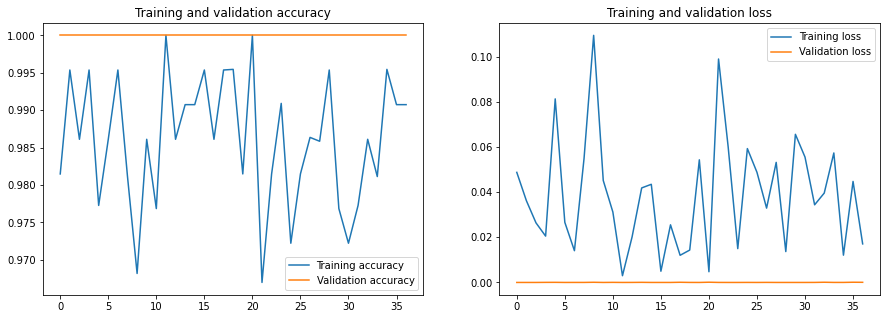

In [10]:
plot_accuracy_and_loss(history)

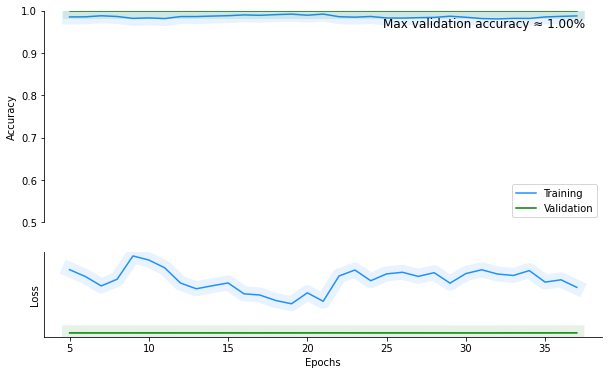

In [11]:
plot_history(history,xkcd=False)

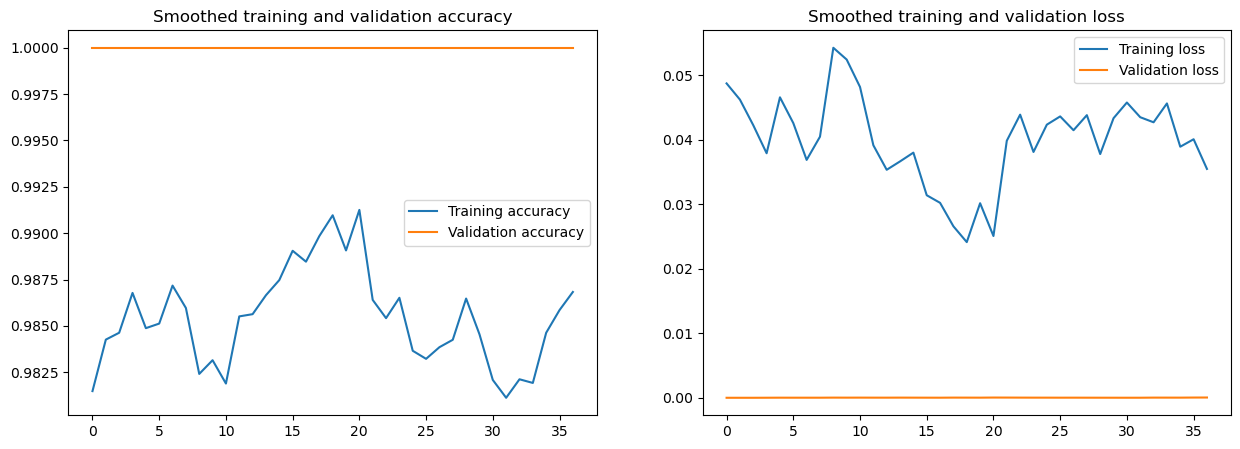

In [12]:
plot_smoothed_acc_and_loss(history, 0.8)

# 3 breeds

## Data preparation

In [13]:
classes = ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog']

train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    PATH + train_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

validation_generator = test_datagen.flow_from_directory(
    PATH + validation_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

test_generator = test_datagen.flow_from_directory(
    PATH + test_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

# Get class labels
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes_labels = []
for i in range(len(inv_class_indices)):
    classes_labels.append(inv_class_indices[i])
print('\nStored classes labels in classes_labels: ', classes_labels)

# Load test images and labels
test_features, test_labels = extract_features(
    generator=test_generator, 
    feature_size=(STD_SIZE[0], STD_SIZE[1], 3), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels))
print(f"\nLoaded test images in test_features array: {test_features.shape}")

with open('classes_encoding_3_breeds', 'wb') as f:
    pickle.dump(classes_labels, f)

Found 412 images belonging to 3 classes.
Found 88 images belonging to 3 classes.
Found 89 images belonging to 3 classes.

Stored classes labels in classes_labels:  ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog']

Loaded test images in test_features array: (89, 299, 299, 3)


## Model

In [14]:
model = load_model(PATH + 'tl_freeze_conv_base_InceptionResNetV2_data_aug_3_breeds')

C:\ProgramData\Anaconda3\envs\virtEnv\lib\site-packages\keras\engine\saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [15]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 8, 8, 1536)        54336736  
_________________________________________________________________
flatten_2 (Flatten)          (None, 98304)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               50332160  
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 1539      
Total params: 104,670,435
Trainable params: 104,609,891
Non-trainable params: 60,544
_________________________________________________________________


In [16]:
set_trainable = False
      
# choose the layers which are updated by training
layer_num = len(model.layers)
for layer in model.layers[:int(layer_num * 0.9)]:
    layer.trainable = False

for layer in model.layers[int(layer_num * 0.9):]:
    layer.trainable = True   

In [17]:
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['acc'])

history = model.fit_generator(
    train_generator, 
    steps_per_epoch=train_generator.n // BATCH_SIZE, epochs=1000, verbose=2,
    validation_data=validation_generator, validation_steps=validation_generator.n // BATCH_SIZE, 
    callbacks=[History(),
               ModelCheckpoint(PATH + 'tl_fine_tuning_InceptionResNetV2_3_breeds', monitor='val_loss', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1)
              ])

with open(PATH + 'tl_fine_tuning_InceptionResNetV2_3_breeds_history', 'wb') as f:
    pickle.dump(history.history, f)

Epoch 1/1000
 - 19s - loss: 0.0199 - acc: 0.9872 - val_loss: 7.0333e-07 - val_acc: 1.0000

Epoch 00001: val_loss improved from inf to 0.00000, saving model to tl_fine_tuning_InceptionResNetV2_3_breeds
Epoch 2/1000
 - 9s - loss: 0.0609 - acc: 0.9796 - val_loss: 1.3351e-06 - val_acc: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/1000
 - 8s - loss: 0.1039 - acc: 0.9847 - val_loss: 2.1782e-04 - val_acc: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/1000
 - 8s - loss: 0.0597 - acc: 0.9821 - val_loss: 9.6776e-05 - val_acc: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/1000
 - 8s - loss: 0.0514 - acc: 0.9850 - val_loss: 2.9802e-08 - val_acc: 1.0000

Epoch 00005: val_loss improved from 0.00000 to 0.00000, saving model to tl_fine_tuning_InceptionResNetV2_3_breeds
Epoch 6/1000
 - 8s - loss: 0.0685 - acc: 0.9844 - val_loss: 6.5565e-08 - val_acc: 1.0000

Epoch 00006: val_loss did not improve from 0.00000
Epoch 7/1000
 - 8s - loss: 0.08

## Results

In [18]:
model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE)

89/89 [==============================] - 3s 30ms/step


[0.0002542838280975006, 1.0]

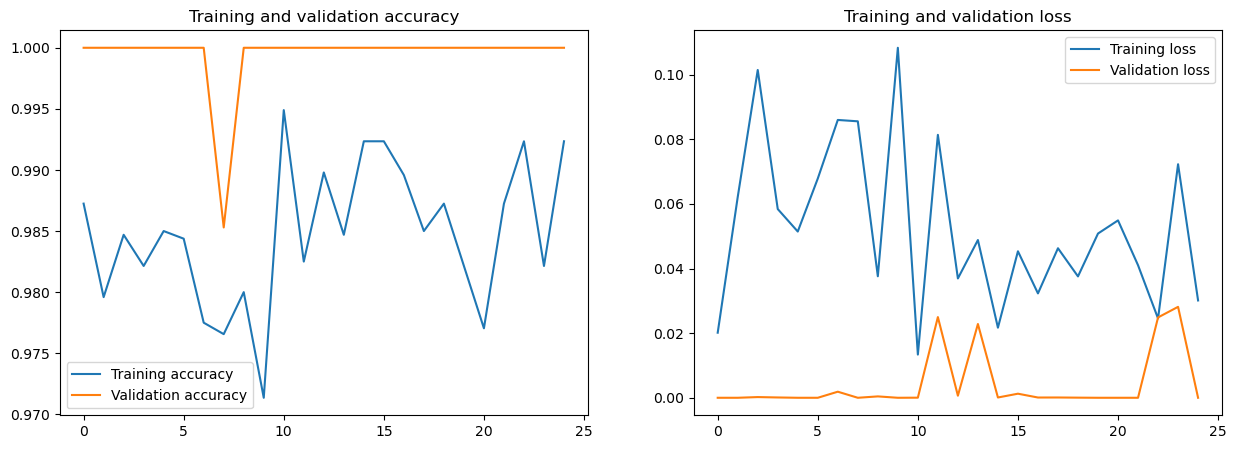

In [19]:
plot_accuracy_and_loss(history)

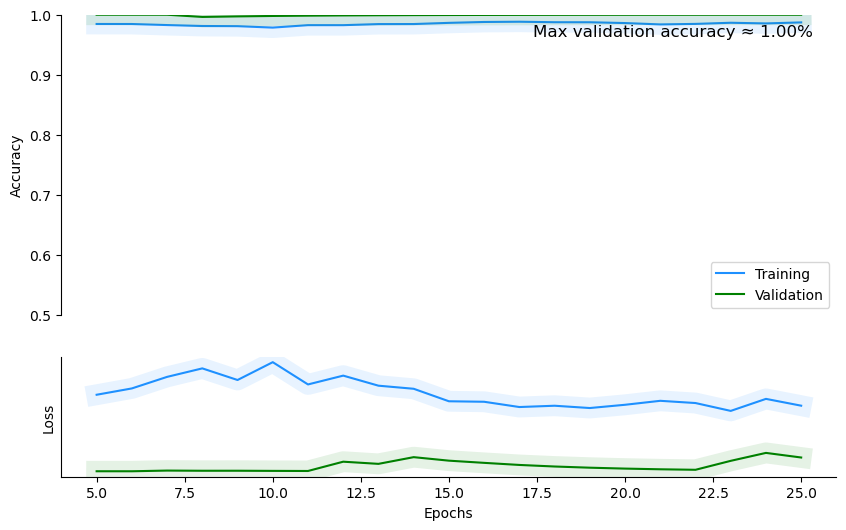

In [20]:
plot_history(history,xkcd=False)

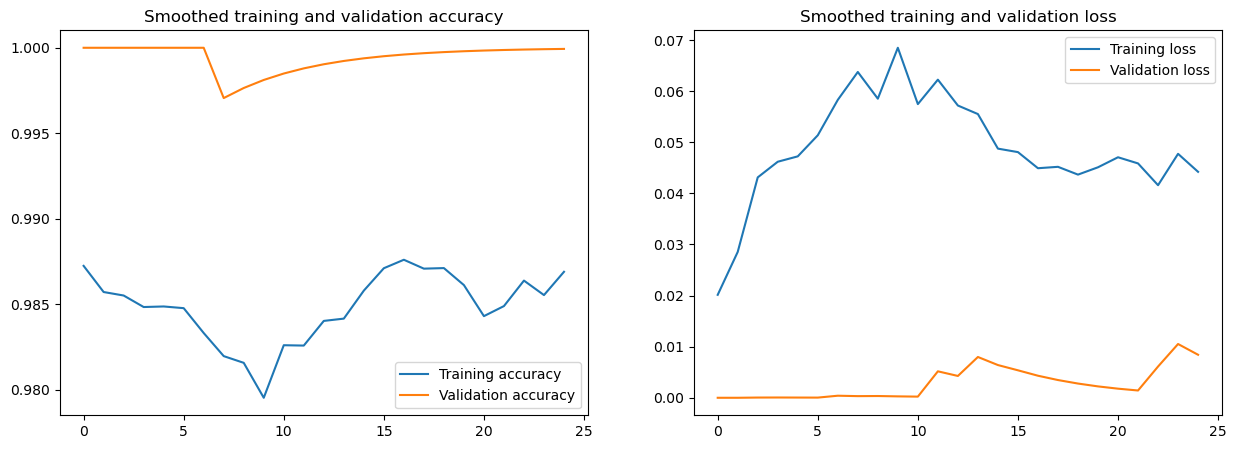

In [21]:
plot_smoothed_acc_and_loss(history, 0.8)

<Figure size 5000x5000 with 0 Axes>

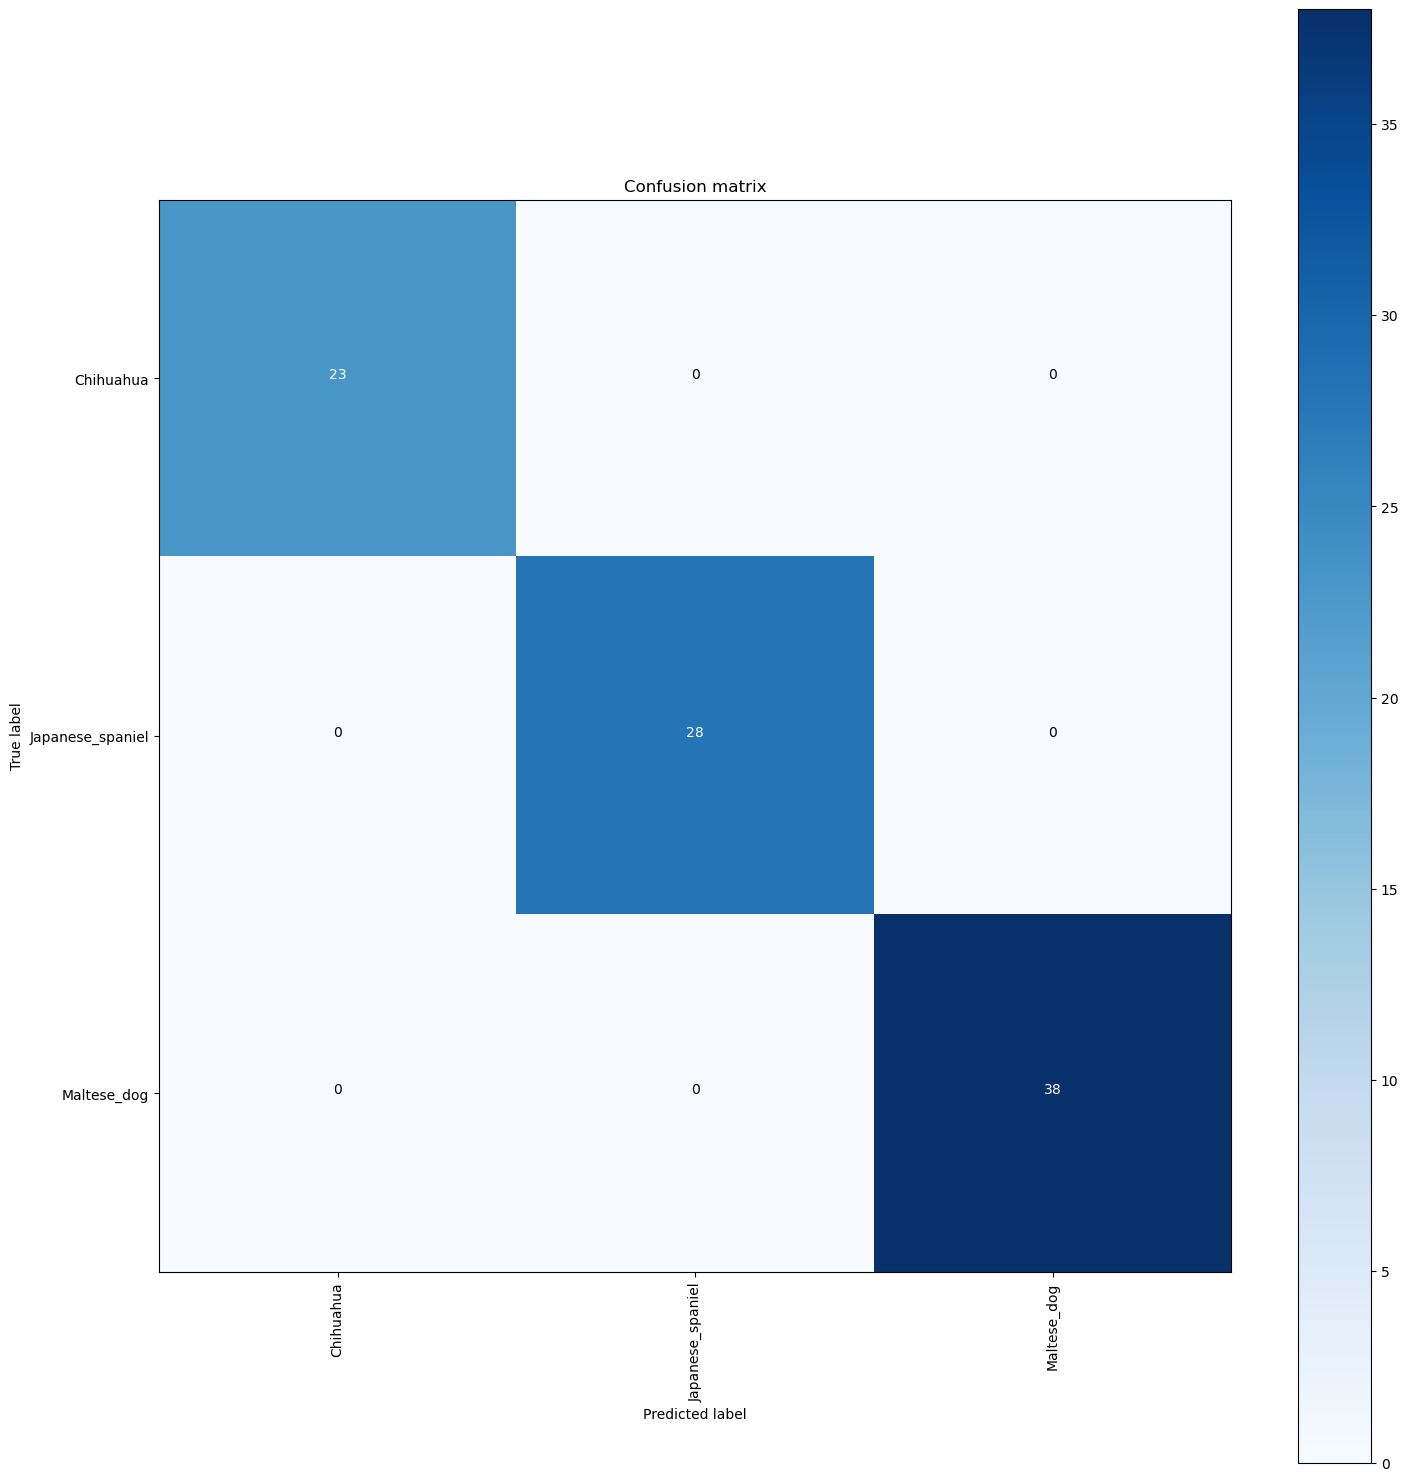

In [22]:
y_true=np.argmax(test_labels, axis=-1)
y_pred=model.predict_classes(test_features)
confusion_mtx = confusion_matrix(y_true, y_pred) 
plot_confusion_matrix(confusion_mtx, 
                      classes=classes_labels)
plt.show()

# 5 breeds

## Data preparation

In [4]:
classes = ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih']

train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    PATH + train_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

validation_generator = test_datagen.flow_from_directory(
    PATH + validation_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

test_generator = test_datagen.flow_from_directory(
    PATH + test_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

# Get class labels
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes_labels = []
for i in range(len(inv_class_indices)):
    classes_labels.append(inv_class_indices[i])
print('\nStored classes labels in classes_labels: ', classes_labels)

# Load test images and labels
test_features, test_labels = extract_features(
    generator=test_generator, 
    feature_size=(STD_SIZE[0], STD_SIZE[1], 3), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels))
print(f"\nLoaded test images in test_features array: {test_features.shape}")

with open('classes_encoding_5_breeds', 'wb') as f:
    pickle.dump(classes_labels, f)

Found 666 images belonging to 5 classes.
Found 143 images belonging to 5 classes.
Found 143 images belonging to 5 classes.

Stored classes labels in classes_labels:  ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih']

Loaded test images in test_features array: (143, 299, 299, 3)


## Model

In [5]:
model = load_model(PATH + 'tl_freeze_conv_base_InceptionResNetV2_data_aug_5_breeds')

C:\ProgramData\Anaconda3\envs\virtEnv\lib\site-packages\keras\engine\saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [6]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 8, 8, 1536)        54336736  
_________________________________________________________________
flatten_3 (Flatten)          (None, 98304)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               50332160  
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 2565      
Total params: 104,671,461
Trainable params: 104,610,917
Non-trainable params: 60,544
_________________________________________________________________


In [7]:
set_trainable = False
      
# choose the layers which are updated by training
layer_num = len(model.layers)
for layer in model.layers[:int(layer_num * 0.9)]:
    layer.trainable = False

for layer in model.layers[int(layer_num * 0.9):]:
    layer.trainable = True   

In [8]:
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['acc'])

history = model.fit_generator(
    train_generator, 
    steps_per_epoch=train_generator.n // BATCH_SIZE, epochs=1000, verbose=2,
    validation_data=validation_generator, validation_steps=validation_generator.n // BATCH_SIZE, 
    callbacks=[History(),
               ModelCheckpoint(PATH + 'tl_fine_tuning_InceptionResNetV2_5_breeds', monitor='val_loss', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1)
              ])

with open(PATH + 'tl_fine_tuning_InceptionResNetV2_5_breeds_history', 'wb') as f:
    pickle.dump(history.history, f)

Epoch 1/1000
 - 29s - loss: 0.1999 - acc: 0.9319 - val_loss: 0.4947 - val_acc: 0.9643

Epoch 00001: val_loss improved from inf to 0.49466, saving model to tl_fine_tuning_InceptionResNetV2_5_breeds
Epoch 2/1000
 - 15s - loss: 0.2251 - acc: 0.9458 - val_loss: 0.1103 - val_acc: 0.9593

Epoch 00002: val_loss improved from 0.49466 to 0.11025, saving model to tl_fine_tuning_InceptionResNetV2_5_breeds
Epoch 3/1000
 - 14s - loss: 0.1898 - acc: 0.9303 - val_loss: 0.0020 - val_acc: 0.9756

Epoch 00003: val_loss improved from 0.11025 to 0.00203, saving model to tl_fine_tuning_InceptionResNetV2_5_breeds
Epoch 4/1000
 - 13s - loss: 0.2709 - acc: 0.9241 - val_loss: 0.0142 - val_acc: 0.9756

Epoch 00004: val_loss did not improve from 0.00203
Epoch 5/1000
 - 13s - loss: 0.2348 - acc: 0.9350 - val_loss: 0.0107 - val_acc: 0.9512

Epoch 00005: val_loss did not improve from 0.00203
Epoch 6/1000
 - 13s - loss: 0.2686 - acc: 0.9272 - val_loss: 0.0493 - val_acc: 0.9593

Epoch 00006: val_loss did not improve 

## Results

In [9]:
model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE)

143/143 [==============================] - 2s 14ms/step


[0.2221259688280793, 0.9650349617004395]

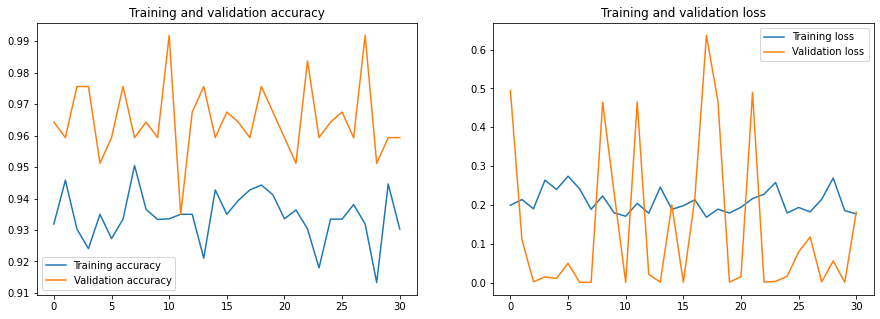

In [10]:
plot_accuracy_and_loss(history)

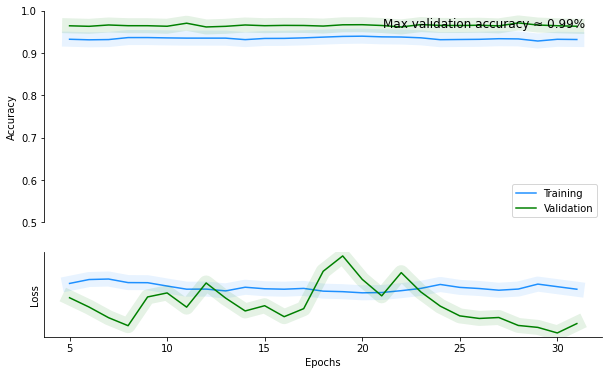

In [11]:
plot_history(history,xkcd=False)

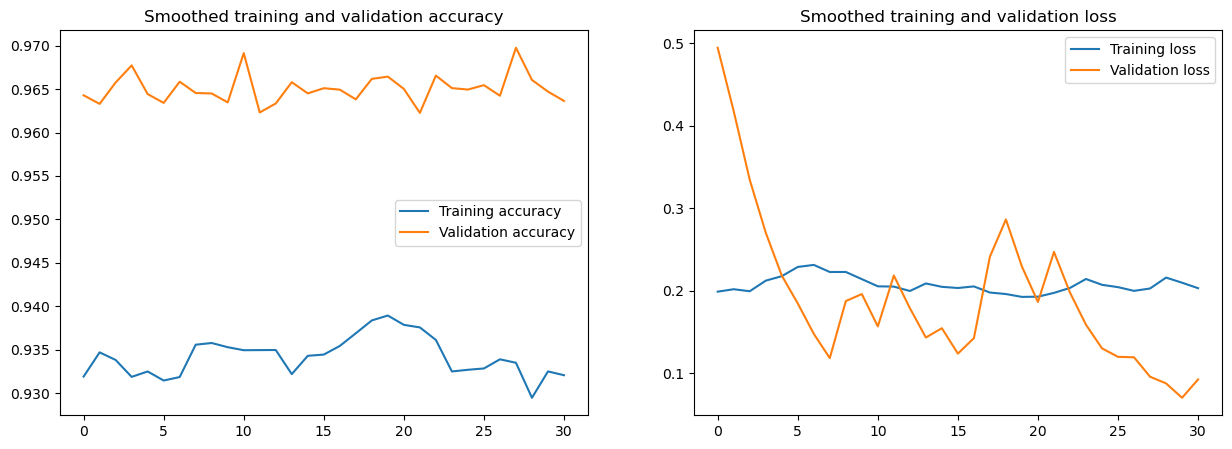

In [12]:
plot_smoothed_acc_and_loss(history, 0.8)

<Figure size 5000x5000 with 0 Axes>

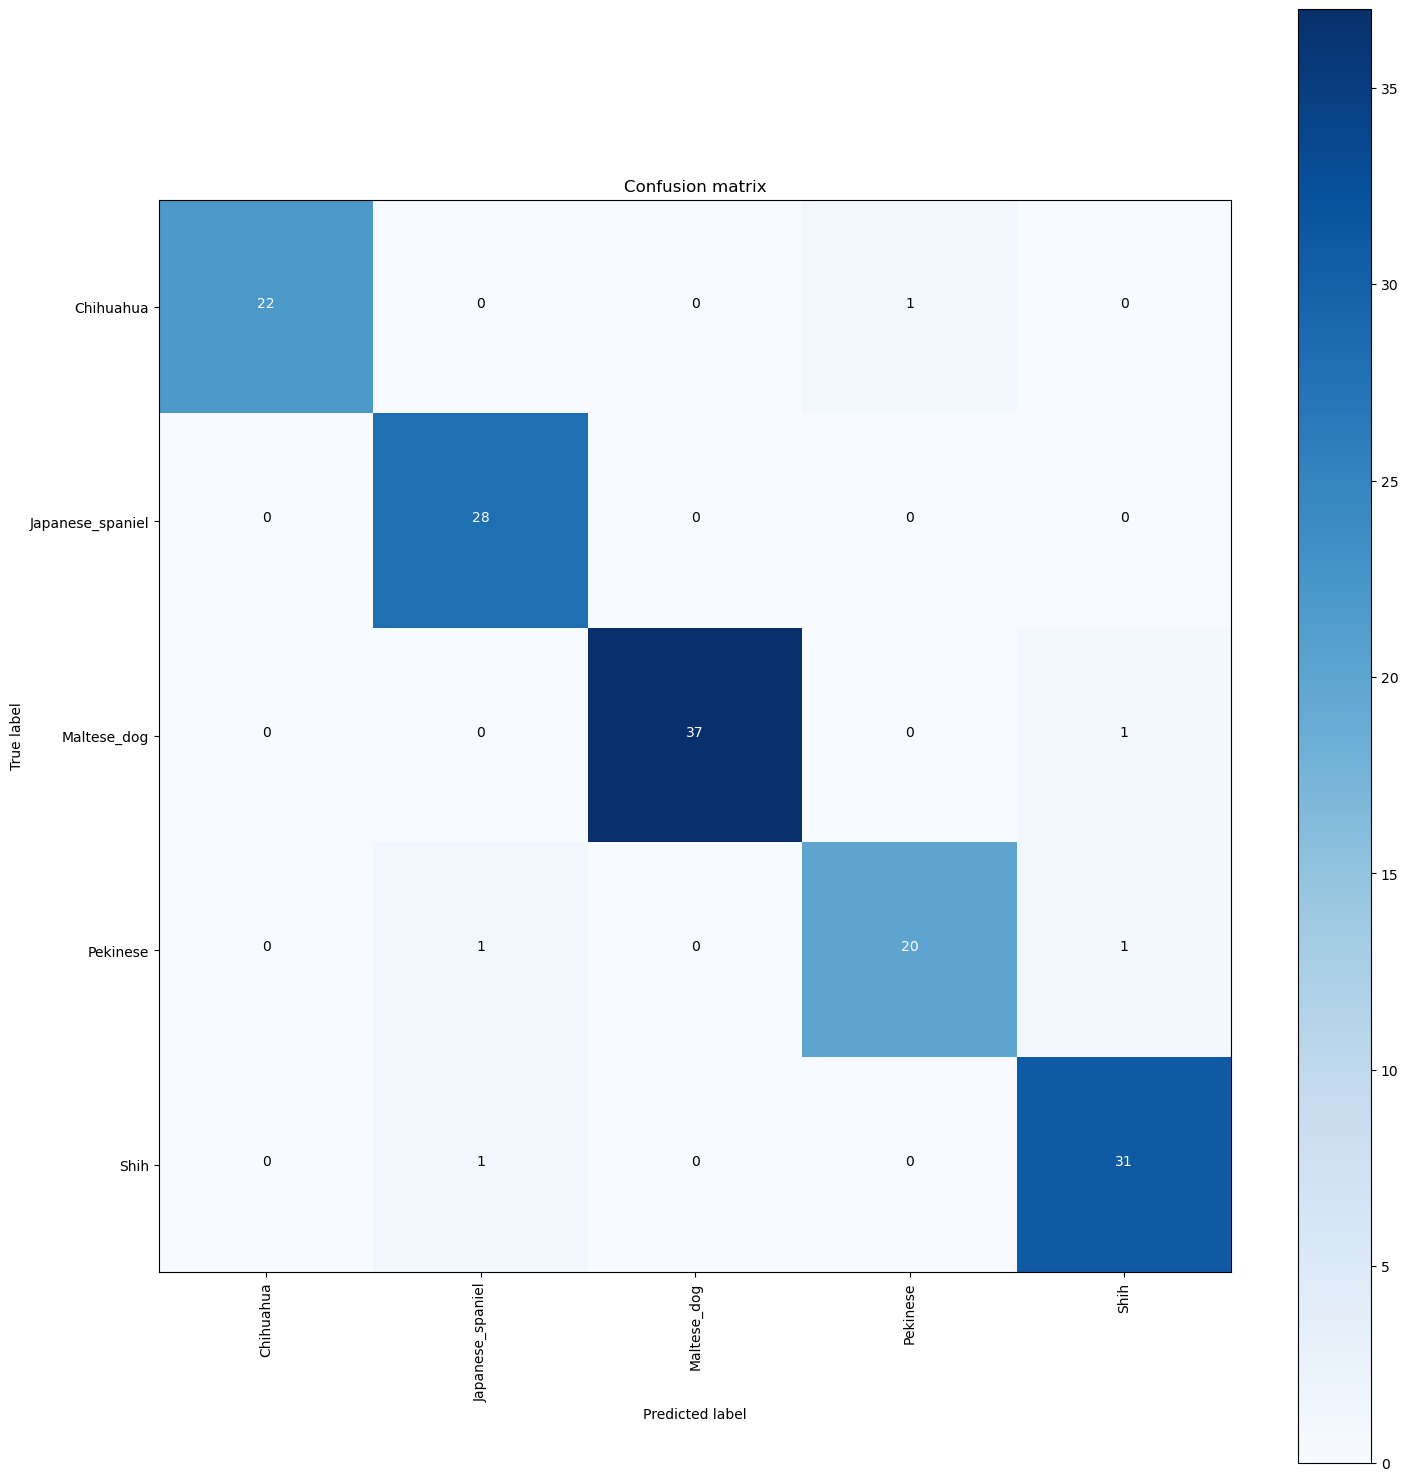

In [13]:
y_true=np.argmax(test_labels, axis=-1)
y_pred=model.predict_classes(test_features)
confusion_mtx = confusion_matrix(y_true, y_pred) 
plot_confusion_matrix(confusion_mtx, 
                      classes=classes_labels)
plt.show()

# 60 breeds

## Data preparation

In [4]:
classes = os.listdir(PATH + train_dir)[:60]

train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    PATH + train_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

validation_generator = test_datagen.flow_from_directory(
    PATH + validation_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

test_generator = test_datagen.flow_from_directory(
    PATH + test_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

# Get class labels
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes_labels = []
for i in range(len(inv_class_indices)):
    classes_labels.append(inv_class_indices[i])
print('\nStored classes labels in classes_labels: ', classes_labels)

# Load test images and labels
test_features, test_labels = extract_features(
    generator=test_generator, 
    feature_size=(STD_SIZE[0], STD_SIZE[1], 3), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels))
print(f"\nLoaded test images in test_features array: {test_features.shape}")

with open('classes_encoding_60_breeds', 'wb') as f:
    pickle.dump(classes_labels, f)

Found 7072 images belonging to 60 classes.
Found 1527 images belonging to 60 classes.
Found 1512 images belonging to 60 classes.

Stored classes labels in classes_labels:  ['affenpinscher', 'Afghan_hound', 'African_hunting_dog', 'Airedale', 'American_Staffordshire_terrier', 'Appenzeller', 'Australian_terrier', 'basenji', 'basset', 'beagle', 'Bedlington_terrier', 'Bernese_mountain_dog', 'black', 'Blenheim_spaniel', 'bloodhound', 'bluetick', 'Border_collie', 'Border_terrier', 'borzoi', 'Boston_bull', 'Bouvier_des_Flandres', 'boxer', 'Brabancon_griffon', 'briard', 'Brittany_spaniel', 'bull_mastiff', 'cairn', 'Cardigan', 'Chesapeake_Bay_retriever', 'Chihuahua', 'chow', 'clumber', 'cocker_spaniel', 'collie', 'curly', 'Dandie_Dinmont', 'dhole', 'dingo', 'Doberman', 'English_foxhound', 'English_setter', 'English_springer', 'EntleBucher', 'Eskimo_dog', 'flat', 'French_bulldog', 'German_shepherd', 'German_short', 'giant_schnauzer', 'golden_retriever', 'Gordon_setter', 'Greater_Swiss_Mountain_do

## Model

In [5]:
model = load_model(PATH + 'tl_freeze_conv_base_data_InceptionResNetV2_aug_60_breeds')

C:\ProgramData\Anaconda3\envs\virtEnv\lib\site-packages\keras\engine\saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [6]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 8, 8, 1536)        54336736  
_________________________________________________________________
flatten_1 (Flatten)          (None, 98304)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               50332160  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 60)                30780     
Total params: 104,699,676
Trainable params: 104,639,132
Non-trainable params: 60,544
_________________________________________________________________


In [7]:
set_trainable = False
      
# choose the layers which are updated by training
layer_num = len(model.layers)
for layer in model.layers[:int(layer_num * 0.9)]:
    layer.trainable = False

for layer in model.layers[int(layer_num * 0.9):]:
    layer.trainable = True   

In [8]:
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['acc'])

history = model.fit_generator(
    train_generator, 
    steps_per_epoch=train_generator.n // BATCH_SIZE, epochs=1000, verbose=2,
    validation_data=validation_generator, validation_steps=validation_generator.n // BATCH_SIZE, 
    callbacks=[History(),
               ModelCheckpoint(PATH + 'tl_fine_tuning_InceptionResNetV2_60_breeds', monitor='val_loss', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
              ])

with open(PATH + 'tl_fine_tuning_InceptionResNetV2_60_breeds_history', 'wb') as f:
    pickle.dump(history.history, f)

Epoch 1/1000
 - 164s - loss: 1.3460 - acc: 0.6987 - val_loss: 0.5817 - val_acc: 0.9461

Epoch 00001: val_loss improved from inf to 0.58171, saving model to tl_fine_tuning_InceptionResNetV2_60_breeds
Epoch 2/1000
 - 154s - loss: 1.2547 - acc: 0.7096 - val_loss: 0.0147 - val_acc: 0.9449

Epoch 00002: val_loss improved from 0.58171 to 0.01472, saving model to tl_fine_tuning_InceptionResNetV2_60_breeds
Epoch 3/1000
 - 155s - loss: 1.1616 - acc: 0.7184 - val_loss: 0.4864 - val_acc: 0.9496

Epoch 00003: val_loss did not improve from 0.01472
Epoch 4/1000
 - 154s - loss: 1.1550 - acc: 0.7262 - val_loss: 0.4320 - val_acc: 0.9509

Epoch 00004: val_loss did not improve from 0.01472
Epoch 5/1000
 - 154s - loss: 1.1095 - acc: 0.7301 - val_loss: 0.4606 - val_acc: 0.9463

Epoch 00005: val_loss did not improve from 0.01472
Epoch 6/1000
 - 155s - loss: 1.0930 - acc: 0.7347 - val_loss: 0.1430 - val_acc: 0.9542

Epoch 00006: val_loss did not improve from 0.01472
Epoch 7/1000
 - 158s - loss: 1.0211 - acc:

## Results

In [9]:
model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE)

1512/1512 [==============================] - 22s 14ms/step


[0.2471179579330421, 0.9384920597076416]

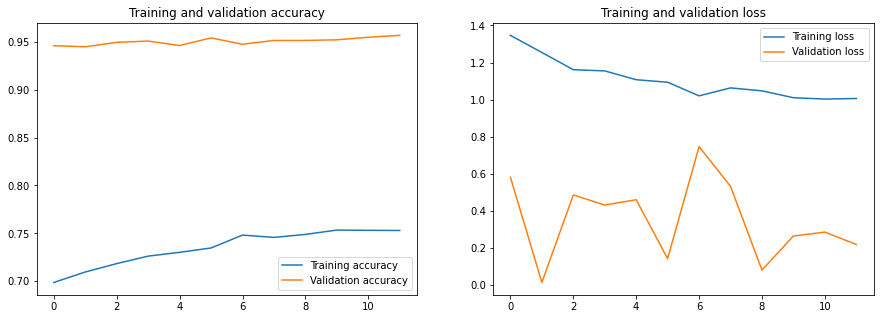

In [10]:
plot_accuracy_and_loss(history)

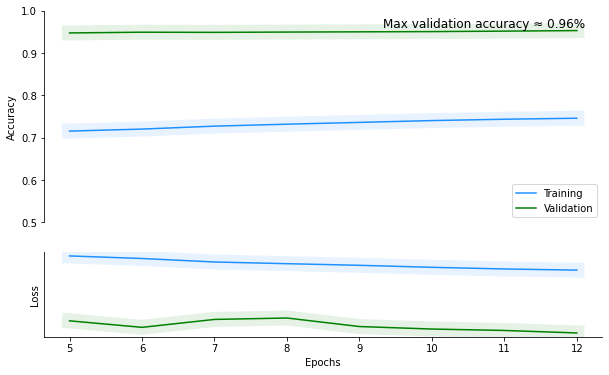

In [11]:
plot_history(history,xkcd=False)

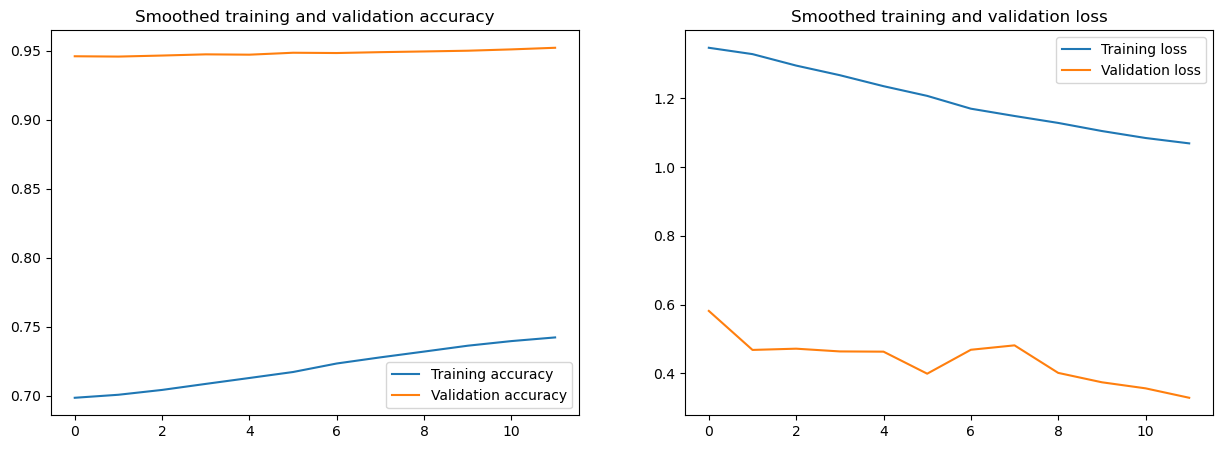

In [12]:
plot_smoothed_acc_and_loss(history, 0.8)

<Figure size 5000x5000 with 0 Axes>

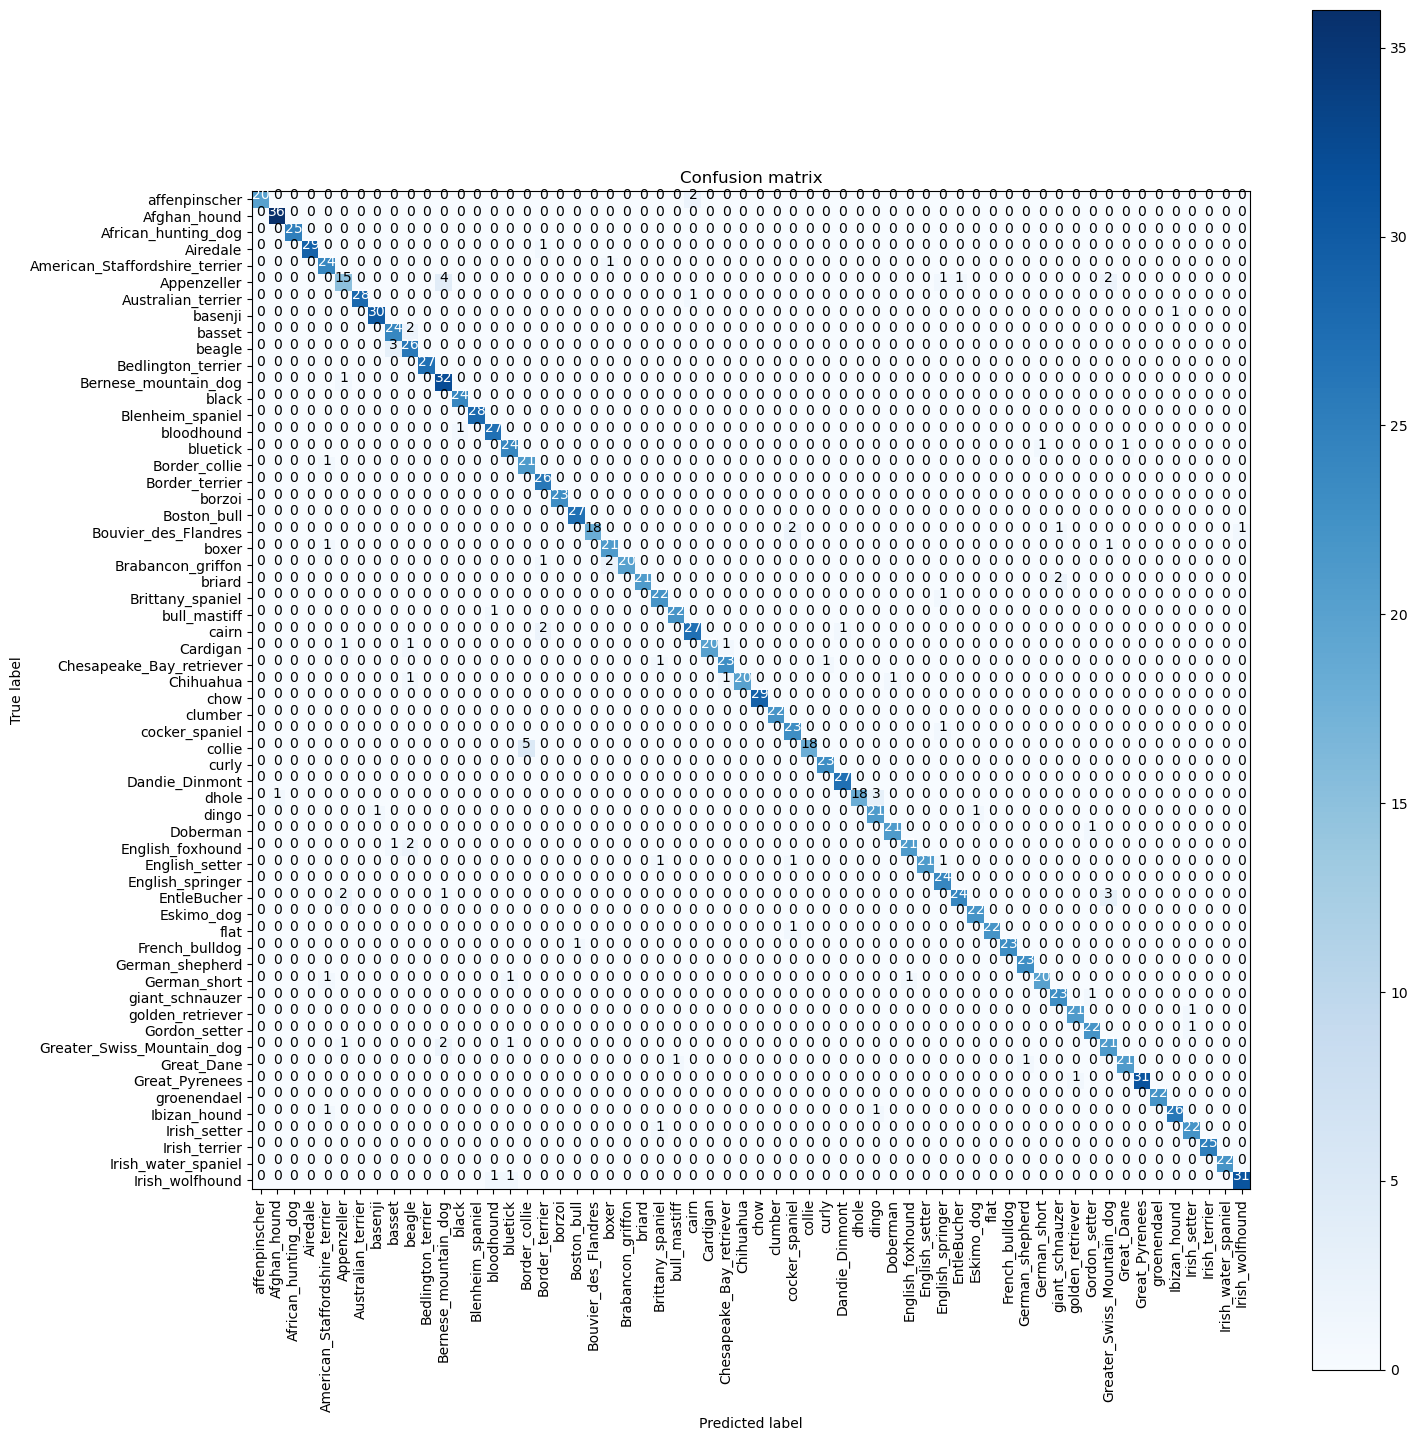

In [13]:
y_true=np.argmax(test_labels, axis=-1)
y_pred=model.predict_classes(test_features)
confusion_mtx = confusion_matrix(y_true, y_pred) 
plot_confusion_matrix(confusion_mtx, 
                      classes=classes_labels)
plt.show()

# 120 breeds

## Data preparation

In [14]:
train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    PATH + train_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    PATH + validation_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    PATH + test_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical')

# Get class labels
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes_labels = []
for i in range(len(inv_class_indices)):
    classes_labels.append(inv_class_indices[i])
print('\nStored classes labels in classes_labels: ', classes_labels)

# Load test images and labels
test_features, test_labels = extract_features(
    generator=test_generator, 
    feature_size=(STD_SIZE[0], STD_SIZE[1], 3), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels))
print(f"\nLoaded test images in test_features array: {test_features.shape}")

with open('classes_encoding_120_breeds', 'wb') as f:
    pickle.dump(classes_labels, f)

Found 14397 images belonging to 120 classes.
Found 3099 images belonging to 120 classes.
Found 3084 images belonging to 120 classes.

Stored classes labels in classes_labels:  ['Afghan_hound', 'African_hunting_dog', 'Airedale', 'American_Staffordshire_terrier', 'Appenzeller', 'Australian_terrier', 'Bedlington_terrier', 'Bernese_mountain_dog', 'Blenheim_spaniel', 'Border_collie', 'Border_terrier', 'Boston_bull', 'Bouvier_des_Flandres', 'Brabancon_griffon', 'Brittany_spaniel', 'Cardigan', 'Chesapeake_Bay_retriever', 'Chihuahua', 'Dandie_Dinmont', 'Doberman', 'English_foxhound', 'English_setter', 'English_springer', 'EntleBucher', 'Eskimo_dog', 'French_bulldog', 'German_shepherd', 'German_short', 'Gordon_setter', 'Great_Dane', 'Great_Pyrenees', 'Greater_Swiss_Mountain_dog', 'Ibizan_hound', 'Irish_setter', 'Irish_terrier', 'Irish_water_spaniel', 'Irish_wolfhound', 'Italian_greyhound', 'Japanese_spaniel', 'Kerry_blue_terrier', 'Labrador_retriever', 'Lakeland_terrier', 'Leonberg', 'Lhasa', '

# Model

In [15]:
model = load_model(PATH + 'tl_freeze_conv_base_InceptionResNetV2_data_aug_120_breeds')

C:\ProgramData\Anaconda3\envs\virtEnv\lib\site-packages\keras\engine\saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [16]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 8, 8, 1536)        54336736  
_________________________________________________________________
flatten_2 (Flatten)          (None, 98304)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               50332160  
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 120)               61560     
Total params: 104,730,456
Trainable params: 104,669,912
Non-trainable params: 60,544
_________________________________________________________________


In [17]:
set_trainable = False
      
# choose the layers which are updated by training
layer_num = len(model.layers)
for layer in model.layers[:int(layer_num * 0.9)]:
    layer.trainable = False

for layer in model.layers[int(layer_num * 0.9):]:
    layer.trainable = True   

In [18]:
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['acc'])

history = model.fit_generator(
    train_generator, 
    steps_per_epoch=train_generator.n // BATCH_SIZE, epochs=1000, verbose=2,
    validation_data=validation_generator, validation_steps=validation_generator.n // BATCH_SIZE, 
    callbacks=[History(),
               ModelCheckpoint(PATH + 'tl_fine_tuning_InceptionResNetV2_120_breeds', monitor='val_loss', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
              ])

with open(PATH + 'tl_fine_tuning_InceptionResNetV2_120_breeds_history', 'wb') as f:
    pickle.dump(history.history, f)

Epoch 1/1000
 - 345s - loss: 1.5277 - acc: 0.6919 - val_loss: 0.0509 - val_acc: 0.8994

Epoch 00001: val_loss improved from inf to 0.05087, saving model to tl_fine_tuning_InceptionResNetV2_120_breeds
Epoch 2/1000
 - 336s - loss: 1.5018 - acc: 0.6940 - val_loss: 0.1247 - val_acc: 0.9026

Epoch 00002: val_loss did not improve from 0.05087
Epoch 3/1000
 - 330s - loss: 1.4990 - acc: 0.7035 - val_loss: 0.2352 - val_acc: 0.9009

Epoch 00003: val_loss did not improve from 0.05087
Epoch 4/1000
 - 310s - loss: 1.5177 - acc: 0.7033 - val_loss: 0.0058 - val_acc: 0.9058

Epoch 00004: val_loss improved from 0.05087 to 0.00581, saving model to tl_fine_tuning_InceptionResNetV2_120_breeds
Epoch 5/1000
 - 318s - loss: 1.4948 - acc: 0.7052 - val_loss: 0.4242 - val_acc: 0.9035

Epoch 00005: val_loss did not improve from 0.00581
Epoch 6/1000
 - 309s - loss: 1.5038 - acc: 0.7042 - val_loss: 0.0441 - val_acc: 0.9055

Epoch 00006: val_loss did not improve from 0.00581
Epoch 7/1000
 - 308s - loss: 1.4538 - ac

## Results

In [19]:
model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE)

3084/3084 [==============================] - 51s 16ms/step


[0.5559798746900367, 0.9014267325401306]

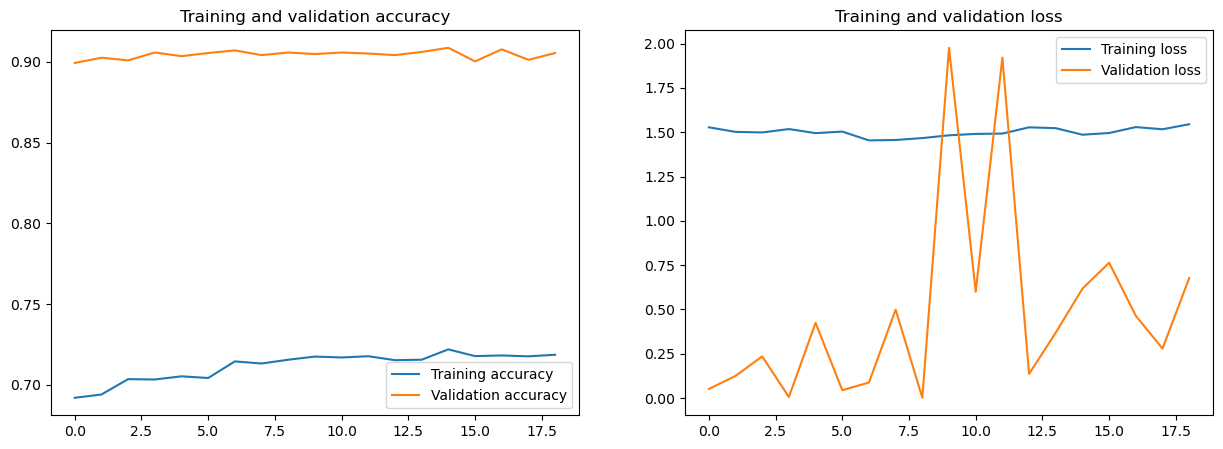

In [20]:
plot_accuracy_and_loss(history)

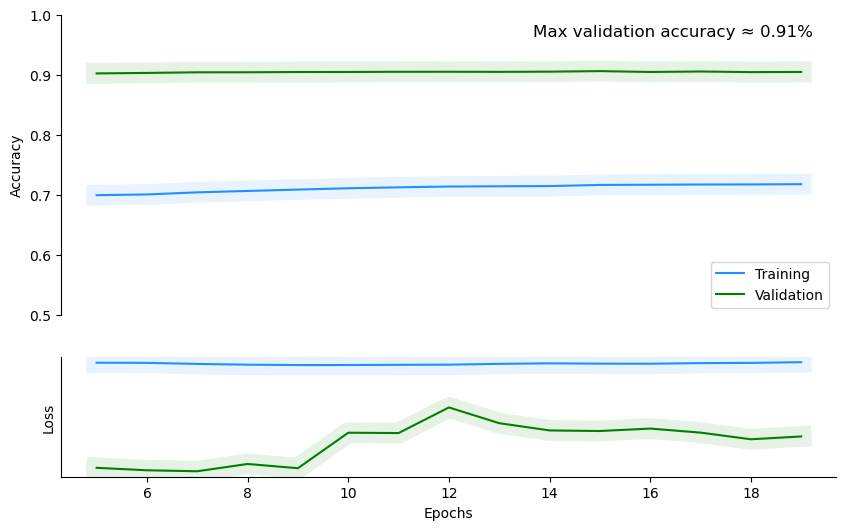

In [21]:
plot_history(history,xkcd=False)

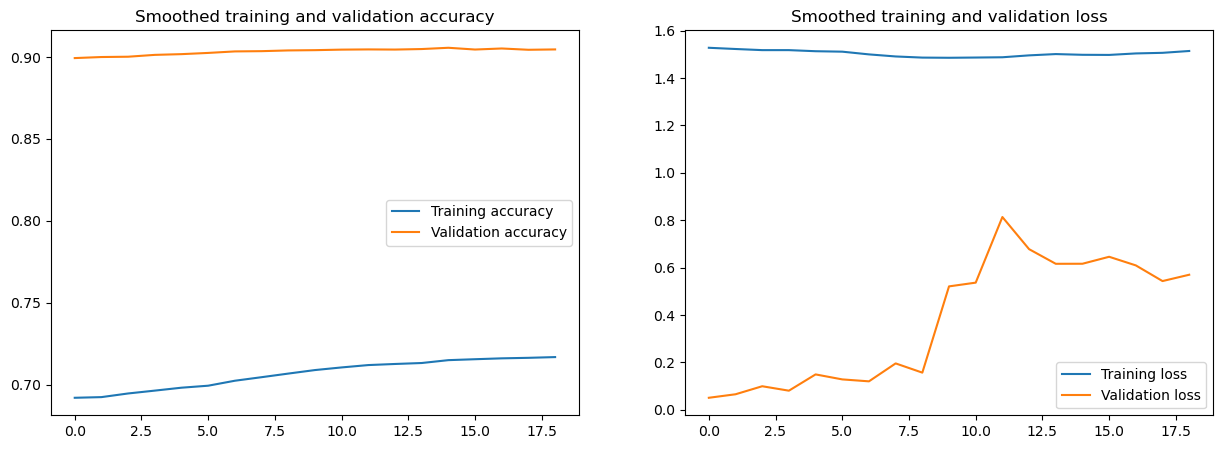

In [22]:
plot_smoothed_acc_and_loss(history, 0.8)

<Figure size 5000x5000 with 0 Axes>

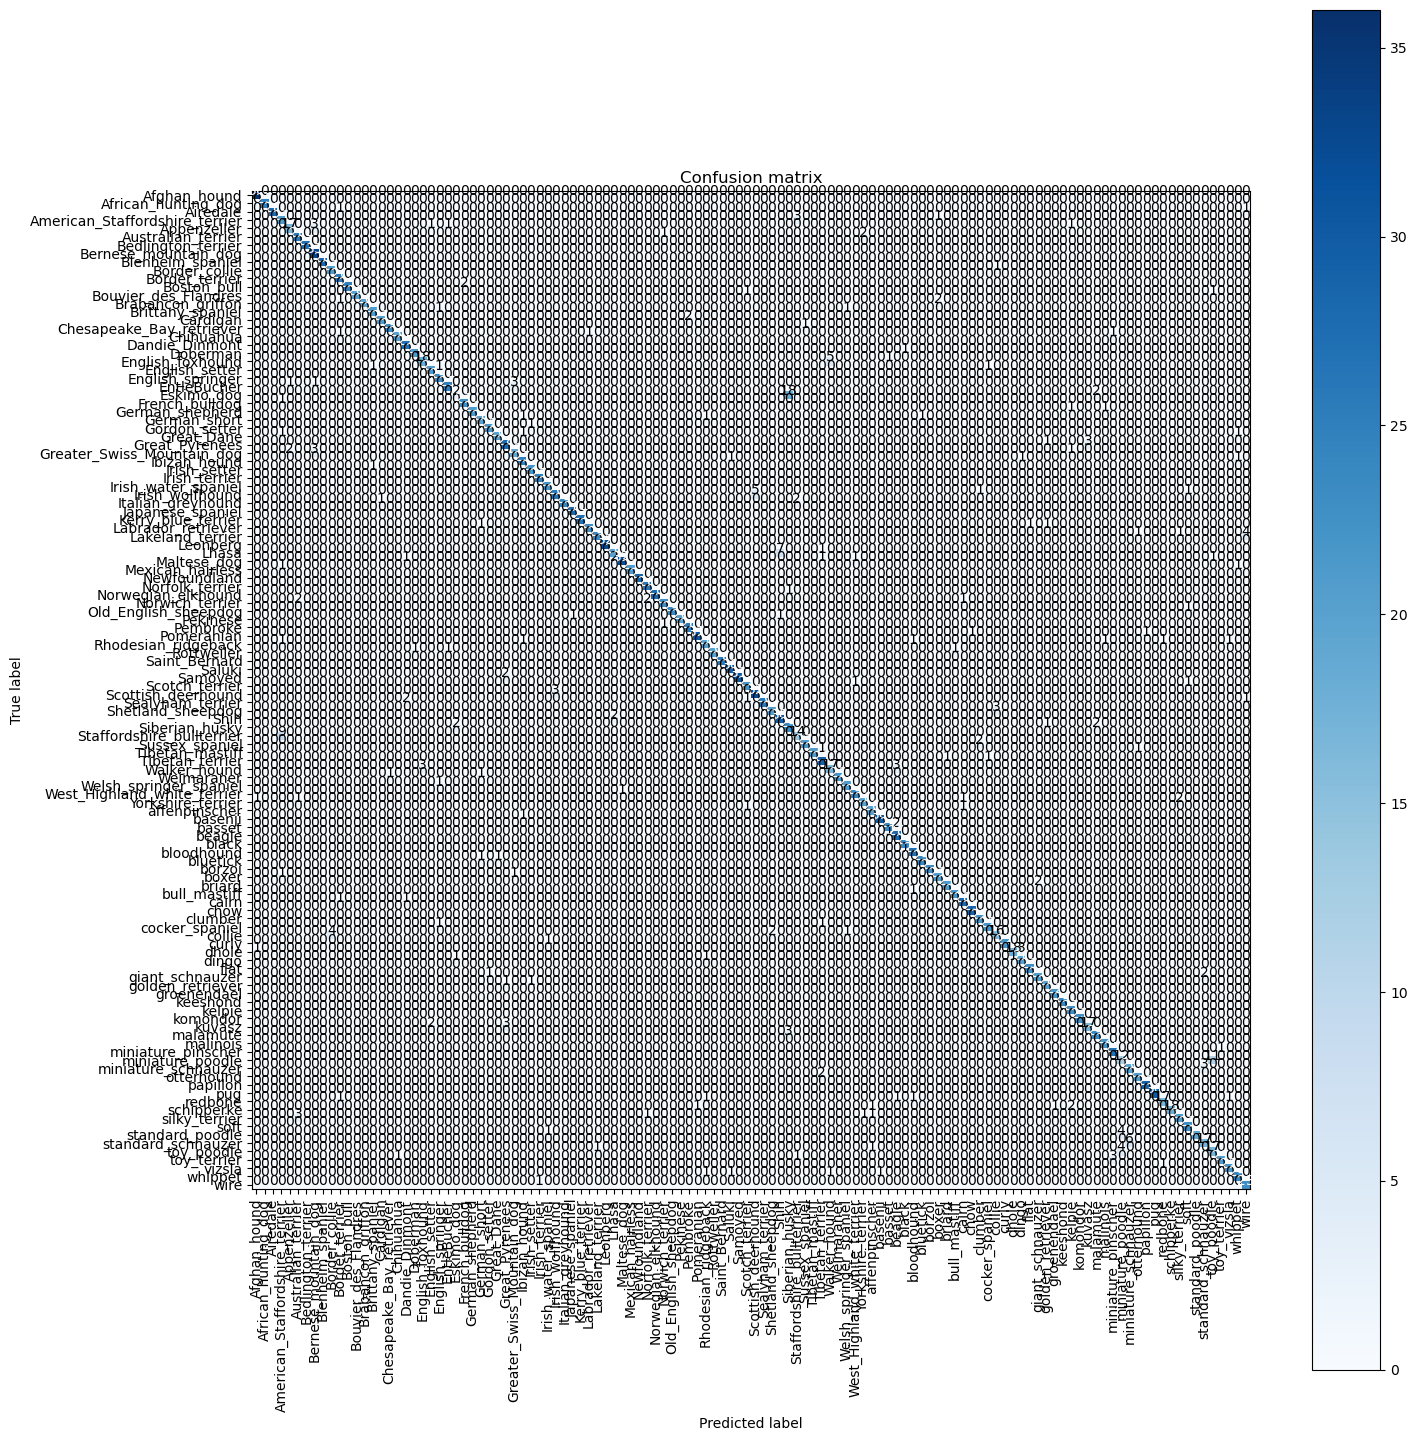

In [23]:
y_true=np.argmax(test_labels, axis=-1)
y_pred=model.predict_classes(test_features)
confusion_mtx = confusion_matrix(y_true, y_pred) 
plot_confusion_matrix(confusion_mtx, 
                      classes=classes_labels)
plt.show()